# Проект модуля. Нейросеть для классификации таблеток

# Постановка задачи

**Бизнес-контекст.** На небольших фармацевтических предприятиях таблетки обычно фасуются по банкам вручную. Последние годы вводятся маленькие автоматические линии для фасовки — они механически расфасовывают таблетки из большой ёмкости по маленьким.

**Проблема.** Процесс фасовки автоматизирован не полностью, специалист должен перепроверять каждую упаковку таблеток. Если в партию случайно попадёт не та таблетка, это можно нанести вред здоровью пациента.

**Бизнес-задача.** Добавить автоматический контроль качества через компьютерное зрение. Для этого нужно разработать алгоритм распознавания таблеток по фото. Это прототип, поэтому достаточно достичь качества распознавания в 75%.

**Формальная задача**. Решить **задачу классификации**, используя CNN. **Входные данные — фото таблетки**, требуемый **результат — название таблетки (из заданного списка)**.

## Критерии успеха
- **Accuracy >= 75%**.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных

Данные предоставлены венгерским Национальным институтом фармации и питания (OGYEI). Датасет содержит изображения таблеток, снятые на однотонном фоне с разными типами освещения и ракурсами, а также классы для них (директории с  jpg-образцами названы по названиям таблеткок). Подробнее — [на странице kaggle.com](https://www.kaggle.com/datasets/richardradli/ogyeiv2/data).


# Инициализация

## Импорт библиотек

In [1]:
!pip install torchinfo -q

In [2]:
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, \
                                         RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
from torchinfo import summary
from sklearn.metrics import classification_report

#from torchvision.models import efficientnet_v2_s
from torchvision.models import efficientnet_b4


import random
import torch.nn as nn
import os

## Установка главных параметров

In [3]:

RANDOM_STATE = 42
TARGET_ACCURACY = 0.75

COLAB = False
EPOCHS = 500
batch_size = 32

DATA_PATH = "/content/drive/MyDrive/ydsc/pills_project/" if COLAB else "./"

In [4]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# Загрузка и предобработка данных

In [5]:
train_dataset_path = os.path.join(DATA_PATH, 'dataset/ogyeiv2/train')
train_dataset = ImageFolder(train_dataset_path)

val_dataset_path = os.path.join(DATA_PATH, 'dataset/ogyeiv2/test')
val_dataset = ImageFolder(val_dataset_path)

Посмотрим на таблетки:

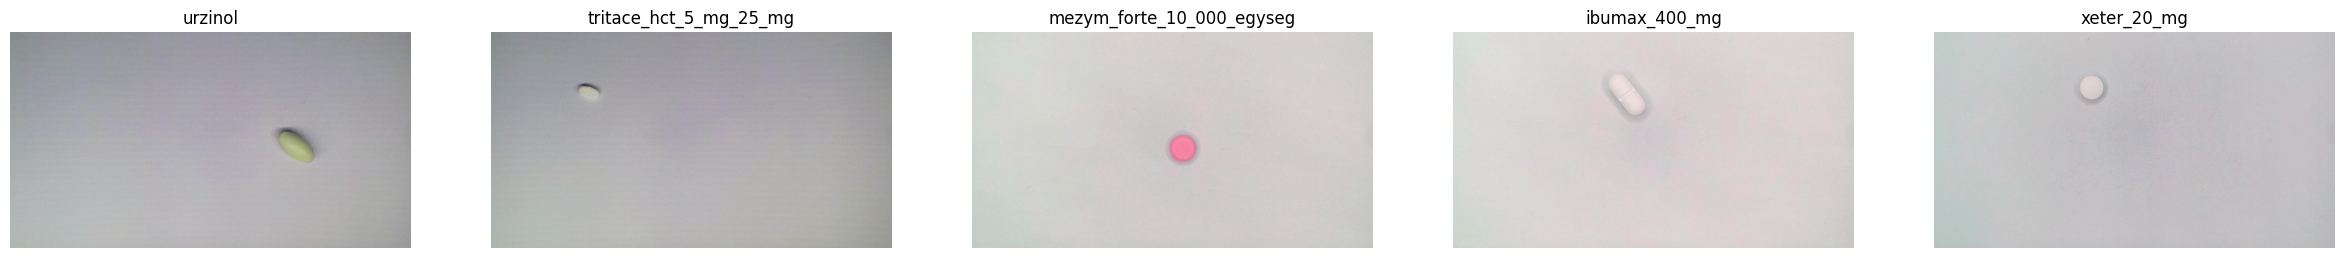

In [6]:
# Визуализация датасета до трансформаций
fig, axes = plt.subplots(1, 5, figsize=(30, 30))
for i in range(5):
    index = random.randint(0, len(train_dataset))
    image, label = train_dataset[index]
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(train_dataset.classes[label])
    ax.axis('off')

Проведём црансформации для датасетов (и аугментацию для тренировочного):

In [7]:

train_transforms = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-7, 7], fill=255.),
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

class TransformDataset(Dataset):
  def __init__(self, dataset, transforms):
    super(TransformDataset, self).__init__()
    self.dataset = dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset[idx]
    return self.transforms(x), y

# Добавление трансформаций к датасетам
train_dataset_transformed = TransformDataset(train_dataset, train_transforms)
val_dataset_transformed = TransformDataset(val_dataset, test_transforms)

Упаковка для обучения в DataLoader

In [8]:
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False)

train_dataset_classes = train_dataset.classes
val_dataset_classes = val_dataset.classes

In [9]:
set(train_dataset_classes) ^ set(val_dataset_classes)

set()

-- состав классов в train и test полностью совпадает.

Посмотрим на размеры датасетов и классов:

In [10]:
print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(val_dataset))

print("Количество классов в train:", len(train_dataset_classes))
print("Количество классов в train:", len(val_dataset_classes))

Количество изображений в train: 2352
Количество изображений в val: 504
Количество классов в train: 84
Количество классов в train: 84


In [11]:
CLASSES_NUM = len(train_dataset_classes)

# Объявление модели

Т. к. таблетки цветные - используем предобученную модель EfficientNet_V2_S_Weights.IMAGENET1K_V1 и перетренеруем её голову-классификатор.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
model = efficientnet_b4(weights='IMAGENET1K_V1')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:01<00:00, 55.7MB/s]


In [14]:
summary(model, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1792, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 48, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 48, 112, 112]         1,296
│    │    └─BatchNorm2d: 3-2                            [1, 48, 112, 112]         96
│    │    └─SiLU: 3-3                                   [1, 48, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 24, 112, 112]         2,940
│    │    └─MBConv: 3-5                                 [1, 24, 112, 112]         1,206
│    └─Sequential: 2-3                                  [1, 32, 56, 56]           --
│    │    └─MBConv: 3-6                            

Заморозим свёрточные слои и заменим классификатор на свой ещё необученный.

На входе у классификатора - 1792 признаков - используем столько же для нашего классификатора. Количество классов - установим вычисленным ранее значением CLASSES_NUM:

In [15]:
# Замена слоя для классификации
# model.classifier = nn.Linear(in_features=1280, out_features=CLASSES_NUM, bias=True)
model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, CLASSES_NUM)
)

# Заморозка слоёв
for param in model.parameters():
    param.requires_grad = False

# Разморозка полносвязного слоя classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Проверка
summary(model, input_size=(1, 3, 224, 224), device=device)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 84]                   --
├─Sequential: 1-1                                       [1, 1792, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 48, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 48, 112, 112]         (1,296)
│    │    └─BatchNorm2d: 3-2                            [1, 48, 112, 112]         (96)
│    │    └─SiLU: 3-3                                   [1, 48, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 24, 112, 112]         (2,940)
│    │    └─MBConv: 3-5                                 [1, 24, 112, 112]         (1,206)
│    └─Sequential: 2-3                                  [1, 32, 56, 56]           --
│    │    └─MBConv: 3-6                    

# Дообучение

In [16]:
%%time

# Настройка гиперпараметров
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
best_vloss = 1e5
train_losses = []
val_losses = []

# Код обучения из прошлого урока
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 20 батчей
        running_loss += loss.item()
        if batch_index % 20 == 19:
            last_loss = running_loss / 20. # средняя ошибка за 20 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка {last_loss}')
            running_loss = 0.

    return last_loss

for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')

    # Перевод модели в режим обучения
    model.train(True)
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)

    # Перевод модели в режим валидации
    model.eval()
    running_vloss = 0.0

    correct = 0
    total = 0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

            # Считаем правильные предсказания
            _, predicted = torch.max(voutputs, 1)
            correct += (predicted == vlabels).sum().item()
            total += vlabels.size(0)

    avg_vloss = running_vloss / (i + 1)
    accuracy = correct / total

    # Сохранение лучшей модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'meds_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}, accuracy {accuracy:.4f}')
    train_losses.append(avg_loss)
    val_losses.append(avg_vloss)

    if accuracy >= TARGET_ACCURACY:
        model_path = f'meds_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)
        print(f'Критерий успеха достигнут на эпохе {epoch}')
        break

Эпоха 0
Эпоха: 0, батч: 19, ошибка 4.596573972702027
Эпоха: 0, батч: 39, ошибка 4.215448415279388
Эпоха: 0, батч: 59, ошибка 3.8309762120246886
В конце эпохи ошибка train 3.8309762120246886, ошибка val 2.895540952682495, accuracy 0.3194
Эпоха 1
Эпоха: 1, батч: 19, ошибка 3.177380919456482
Эпоха: 1, батч: 39, ошибка 2.9423301458358764
Эпоха: 1, батч: 59, ошибка 2.682788443565369
В конце эпохи ошибка train 2.682788443565369, ошибка val 2.0093705654144287, accuracy 0.4762
Эпоха 2
Эпоха: 2, батч: 19, ошибка 2.449616241455078
Эпоха: 2, батч: 39, ошибка 2.421956419944763
Эпоха: 2, батч: 59, ошибка 2.294641077518463
В конце эпохи ошибка train 2.294641077518463, ошибка val 1.558541178703308, accuracy 0.5853
Эпоха 3
Эпоха: 3, батч: 19, ошибка 2.1752861976623534
Эпоха: 3, батч: 39, ошибка 2.1760730683803557
Эпоха: 3, батч: 59, ошибка 2.02828534245491
В конце эпохи ошибка train 2.02828534245491, ошибка val 1.3625940084457397, accuracy 0.6131
Эпоха 4
Эпоха: 4, батч: 19, ошибка 2.0326024115085604
Э

# Оценка качества

In [17]:
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():

    for i, vdata in enumerate(val_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)

        outputs = model(vinputs)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.cpu().numpy())
        labels_true.extend(vlabels.cpu().numpy())

print(classification_report(labels_true, labels_predicted, target_names=val_dataset.classes))

                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       0.50      0.17      0.25         6
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       0.83      0.83      0.83         6
             ambroxol_egis_30_mg       0.62      0.83      0.71         6
                  apranax_550_mg       0.86      1.00      0.92         6
            aspirin_ultra_500_mg       0.40      0.67      0.50         6
                    atoris_20_mg       0.67      1.00      0.80         6
         atorvastatin_teva_20_mg       0.40      0.67      0.50         6
                   betaloc_50_mg       1.00      0.67      0.80         6
                        bila_git     

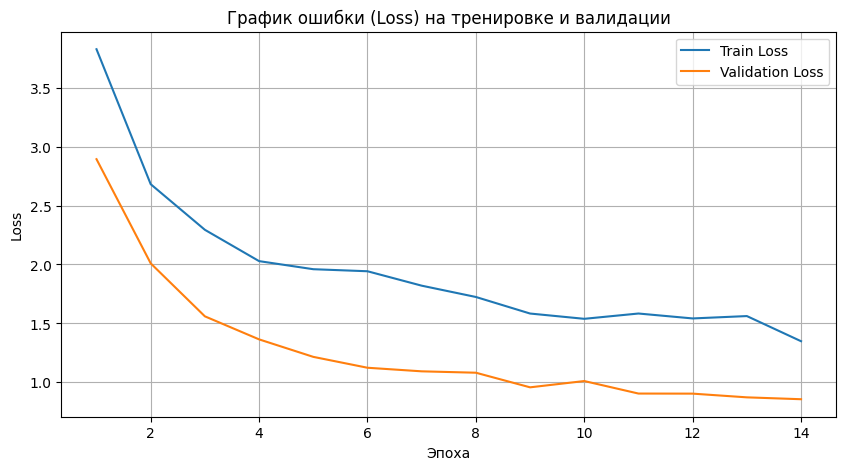

In [18]:
# Преобразуем потери в обычные числа
train_losses_float = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_float = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses_float)+1), train_losses_float, label='Train Loss')
plt.plot(range(1, len(val_losses_float)+1), val_losses_float, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График ошибки (Loss) на тренировке и валидации')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
import pandas as pd

In [30]:
report_dict = classification_report(labels_true, labels_predicted, 
                                    target_names=val_dataset.classes, output_dict=True)

df = pd.DataFrame(report_dict).transpose()

# Фильтруем только реальные классы (не 'accuracy', 'macro avg', 'weighted avg')
df_classes = df.loc[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]

# Сортируем по f1-score
df_sorted = df_classes.sort_values(by='f1-score', ascending=False)

In [35]:
pd.options.display.max_rows = 100

In [46]:
df_sorted

,precision,recall,f1-score,support
acc_long_600_mg,1.000000,1.000000,1.000000,6.0
advil_ultra_forte,1.000000,1.000000,1.000000,6.0
algoflex_forte_dolo_400_mg,1.000000,1.000000,1.000000,6.0
algoflex_rapid_400_mg,1.000000,1.000000,1.000000,6.0
cataflam_50_mg,1.000000,1.000000,1.000000,6.0
cataflam_dolo_25_mg,1.000000,1.000000,1.000000,6.0
c_vitamin_teva_500_mg,1.000000,1.000000,1.000000,6.0
voltaren_dolo_rapid_25_mg,1.000000,1.000000,1.000000,6.0
urzinol,1.000000,1.000000,1.000000,6.0
jutavit_c_vitamin,1.000000,1.000000,1.000000,6.0


In [62]:
best_cat = df_sorted [df_sorted['f1-score'] == 1].index.to_list()
best_cat

['acc_long_600_mg',
 'advil_ultra_forte',
 'algoflex_forte_dolo_400_mg',
 'algoflex_rapid_400_mg',
 'cataflam_50_mg',
 'cataflam_dolo_25_mg',
 'c_vitamin_teva_500_mg',
 'voltaren_dolo_rapid_25_mg',
 'urzinol',
 'jutavit_c_vitamin',
 'condrosulf_800_mg',
 'concor_10_mg',
 'sinupret_forte',
 'valeriana_teva',
 'zadex_60_mg']

In [63]:
worst_cat = df_sorted [df_sorted['f1-score'] < 0.5].tail(5).index.to_list()
worst_cat

['teva_ambrobene_30_mg',
 'normodipine_5_mg',
 'sedatif_pc',
 'akineton_2_mg',
 'naturland_d_vitamin_forte']

In [64]:
from PIL import Image

In [65]:
def show_images (dataset_root, needed_dirs):

    num_images = len(needed_dirs)
    fig, axs = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

    if num_images == 1:
        axs = [axs]

    for i, class_name in enumerate(needed_dirs):
        class_dir = os.path.join(dataset_root, class_name)
        
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"В папке {class_name} нет изображений.")
            continue
        
        # Загружаем первую картинку
        image_path = os.path.join(class_dir, image_files[0])
        image = Image.open(image_path)
        
        # Отображаем
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(class_name)

    plt.tight_layout()
    plt.show()


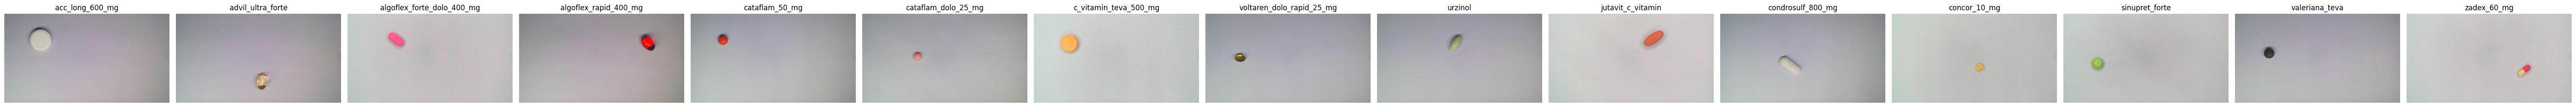

In [66]:
show_images (os.path.join(DATA_PATH, 'dataset/ogyeiv2/test'), best_cat)


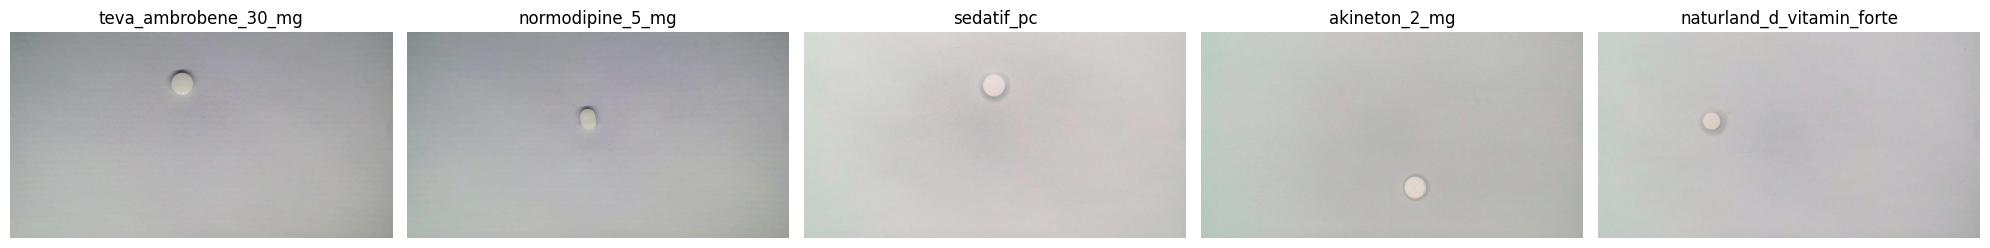

In [67]:
show_images (os.path.join(DATA_PATH, 'dataset/ogyeiv2/test'), worst_cat)

# Выводы

- На каких 5 классах модель ошибается чаще всего?
    - teva_ambrobene_30_mg
    - normodipine_5_mg
    - sedatif_pc
    - akineton_2_mg
    - naturland_d_vitamin_fort
- Почему модель может ошибаться на этих классах?
    - таблетки слишком похожи
- На каких классах модель не совершает ошибок?
    - acc_long_600_mg
    - advil_ultra_forte
    - algoflex_forte_dolo_400_mg
    - algoflex_rapid_400_mg
    - cataflam_50_mg
    - cataflam_dolo_25_mg
    - c_vitamin_teva_500_mg
    - voltaren_dolo_rapid_25_mg
    - urzinol
    - jutavit_c_vitamin
    - condrosulf_800_mg
    - concor_10_mg
    - sinupret_forte
    - valeriana_teva
    - zadex_60_m
- Почему эти классы модель распознаёт безошибочно?
    - они разных цветов и форм
- Как можно улучшить точность классификатора?
    - можно попоробовать другие модели, гиперпараметры и аугментацию
    - можно ещё увеличить обучающую коллекцию
- Как ещё можно проанализировать результаты и ошибки модели?
    - можно ещё увеличить тестовую коллекцию